# Pendulum

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    \tau
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the pendulum upright:
$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0
    \end{bmatrix}
\end{equation*}
$$

**Note**: To deal with angle wrap-around issues, we augment the state as follows:

$$
\begin{equation*}
\hat{\textbf{x}} = \begin{bmatrix}
    \dot{\theta} & \sin{\theta} & \cos{\theta}
    \end{bmatrix}
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by instead fitting
for unconstrained actions and then applying it to a squashing function $\tanh(\textbf{u})$.
This is directly embedded into the dynamics model in order to be auto-differentiated.
This also means that we need to apply this transformation manually to the output of our
controller at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pddp
import pddp.examples

In [5]:
import torch
import numpy as np

In [6]:
DT = 0.05  # Time step (s).
RENDER = True  # Whether to render the environment or not.
CONSTRAIN = True  # Whether to constrain the action space or not.
MIN_BOUNDS = -1.0  # Minimum torque (N m).
MAX_BOUNDS = +1.0  # Maximum torque (N m).
N = 150 if CONSTRAIN else 50  # Horizon length.

# Disable uncertainty since we are dealing with known dynamics.
ENCODING = pddp.StateEncoding.IGNORE_UNCERTAINTY

In [7]:
cost = pddp.examples.pendulum.PendulumCost()
model = pddp.examples.pendulum.PendulumDynamicsModel(DT)
env = pddp.examples.pendulum.PendulumEnv(dt=DT, render=RENDER)

In [8]:
if CONSTRAIN:
    # Constrain the environment and model.
    pddp.utils.constraint.constrain_env(env, MIN_BOUNDS, MAX_BOUNDS)
    pddp.utils.constraint.constrain_model(model, MIN_BOUNDS, MAX_BOUNDS)

In [9]:
def plot(Z, U):
    t = np.arange(N + 1) * DT
    X = pddp.utils.angular.reduce_state(Z, model.angular_indices,
                                        model.non_angular_indices)
    X = X.detach().numpy()
    if CONSTRAIN:
        U = pddp.utils.constraint.constrain(U, MIN_BOUNDS, MAX_BOUNDS)
    U = U.detach().numpy()

    theta = np.unwrap(X[:, 0])  # Makes for smoother plots.
    theta_dot = X[:, 1]
    
    plt.figure()
    plt.plot(theta, theta_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Orientation Phase Plot")

    plt.figure()
    plt.plot(t, theta)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Orientation path")

    plt.figure()
    plt.plot(t, theta_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Angular velocity path")
    
    plt.figure()
    plt.plot(t[:-1], U)
    plt.xlabel("Time (s)")
    plt.ylabel("Torque (N m)")
    plt.title("Constrained action path")
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [10]:
def on_iteration(iteration, Z, U, J_opt, accepted, converged):
    J_opt = J_opt.detach().numpy()

    J_hist.append(J_opt)
    info = "CONVERGED" if converged else ("accepted" if accepted else "FAILED")
    final_state = pddp.utils.angular.reduce_state(Z[-1], model.angular_indices,
                                                  model.non_angular_indices).detach().numpy()
    print("iteration", iteration + 1, info, J_opt, final_state)

In [11]:
controller = pddp.controllers.PDDPController(env, model, cost)

In [12]:
U = torch.randn(N, model.action_size, requires_grad=True)

In [13]:
J_hist = []
controller.eval()
env.reset()
Z, U = controller.fit(U, encoding=ENCODING, n_iterations=200, on_iteration=on_iteration)

iteration 1 accepted 57945.008 [-1.8357946   0.09140527]
iteration 2 accepted 57768.42 [-1.2632052  4.267027 ]
iteration 3 accepted 52713.656 [0.49021068 1.30689   ]
iteration 4 accepted 50477.258 [-0.0178071 -1.1918397]
iteration 5 accepted 48344.605 [ 0.3614129 -2.1824112]
iteration 6 accepted 47544.332 [ 1.0069544 -3.5080528]
iteration 7 accepted 47034.61 [ 1.3649893 -3.8875587]
iteration 8 accepted 46623.39 [ 1.5093182 -3.8376591]
iteration 9 accepted 46540.67 [ 1.6123215 -4.0113144]
iteration 10 accepted 43939.414 [-1.3045956 -3.5486753]
iteration 11 accepted 41150.24 [-0.0911824  1.4692916]
iteration 12 accepted 40755.777 [-0.8007476  3.4632509]
iteration 13 accepted 40626.152 [-0.86850715  3.4568233 ]
iteration 14 accepted 40312.816 [2.4465368 6.0587716]
iteration 15 accepted 34698.934 [0.8264299 0.8722838]
iteration 16 accepted 34515.71 [0.7205239  0.28379205]
iteration 17 accepted 34410.35 [ 0.626981   -0.32128897]
iteration 18 accepted 34386.01 [ 0.55126005 -0.9329121 ]
itera

iteration 147 accepted 25275.049 [0.01719785 0.1088734 ]
iteration 148 accepted 25230.846 [0.04027485 0.06933711]
iteration 149 accepted 25205.947 [0.05381824 0.01929044]
iteration 150 FAILED 25205.947 [0.05381824 0.01929044]
iteration 151 FAILED 25205.947 [0.05381824 0.01929044]
iteration 152 FAILED 25205.947 [0.05381824 0.01929044]
iteration 153 FAILED 25205.947 [0.05381824 0.01929044]
iteration 154 FAILED 25205.947 [0.05381824 0.01929044]
iteration 155 FAILED 25205.947 [0.05381824 0.01929044]
iteration 156 FAILED 25205.947 [0.05381824 0.01929044]
iteration 157 accepted 25168.363 [-0.07924277 -0.13216919]
iteration 158 accepted 25132.256 [-0.04696948 -0.02779643]
iteration 159 accepted 25121.738 [-1.5086553e-05  1.6610404e-02]
iteration 160 FAILED 25121.734 [-1.5086553e-05  1.6610404e-02]
iteration 161 FAILED 25121.734 [-1.5086553e-05  1.6610404e-02]
iteration 162 FAILED 25121.734 [-1.5086553e-05  1.6610404e-02]
iteration 163 FAILED 25121.734 [-1.5086553e-05  1.6610404e-02]
iteration

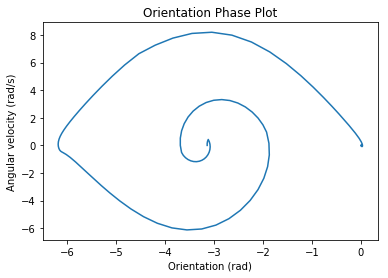

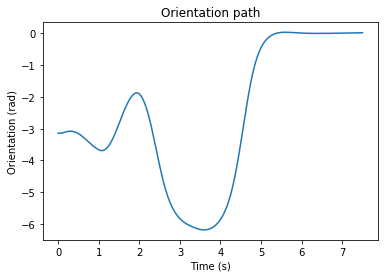

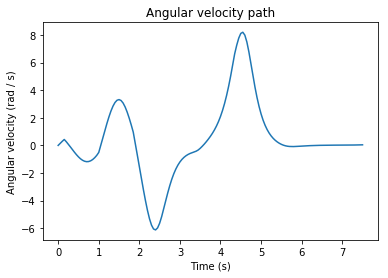

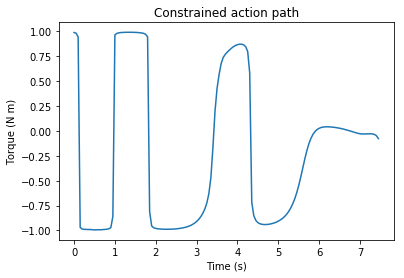

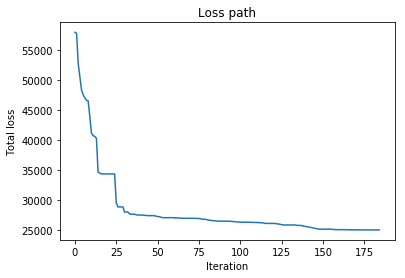

In [14]:
plot(Z, U)

In [15]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


In [16]:
import time

for i, u in enumerate(U):
    env.apply(u)
    time.sleep(DT)

In [17]:
env.close()